In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
from datetime import datetime
from MCForecastTools import MCSimulation
%matplotlib inline

In [2]:
load_dotenv()

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [3]:
stock_dict = {}

stock_list = []

date = input("Pick a start date for your analysis (YYYY-MM-DD): ")

while (True):
    name = input("Add a stock ticker to the list: ")
    stock_dict[name] = date
    stock_list.append(name)
    cont = input("Press 'y' to Add Another Stock, press 'Enter' to exit")
    if cont == "":
        break;

Pick a start date for your analysis (YYYY-MM-DD):  2015-01-01
Add a stock ticker to the list:  MSFT
Press 'y' to Add Another Stock, press 'Enter' to exit y
Add a stock ticker to the list:  TSLA
Press 'y' to Add Another Stock, press 'Enter' to exit 


In [4]:
def stockCreation(stock_dict, stock_list):
    func_list = []
    today = datetime.now().strftime("%Y-%m-%d")
    today = pd.Timestamp(today, tz="America/New_York").isoformat()

    timeframe = "1D"

    portfolio = alpaca.get_barset(
        stock_list,
        timeframe,
        start = date,
        end = today
    ).df
    
    for key, value in stock_dict.items():
        globals()[key] = portfolio[key]["close"]
        func_list.append(globals()[key])
    
    portfolio_close = pd.concat(func_list, axis='columns', join='inner')
    portfolio_close.columns = stock_list
    
    return portfolio, portfolio_close

In [5]:
portfolio = stockCreation(stock_dict, stock_list)[0]

In [6]:
portfolio_close = stockCreation(stock_dict, stock_list)[1]

# Monte Carlo Simulation

### Definition: Computational algorithms that rely on repeated random sampling to obtain numerical results. 

### Purpose: The underlying concept is to use randomness to solve problems that might be deterministic in principle.

In [7]:
num_years = int(input("How many years do you want to run the Monte Carlo Simulation for?"))
    
sims = int(input("How many simulations would you like to run?"))

MC = MCSimulation(
        portfolio_data = portfolio,
        weights = np.full((1,len(portfolio_close.columns)), 1/len(portfolio_close.columns))[0].tolist(),
        num_simulation = sims,
        num_trading_days = 252*num_years
    )

cumu_return = MC.calc_cumulative_return()

How many years do you want to run the Monte Carlo Simulation for? 10
How many simulations would you like to run? 250


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

### Each line represents one simulation of possible outcomes of this portfolio.

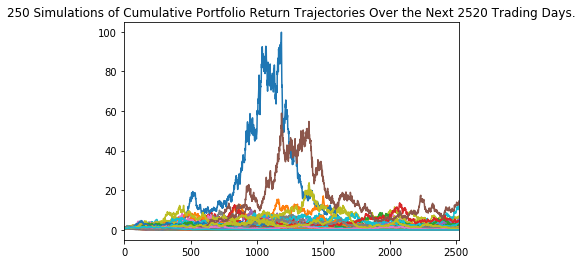

In [8]:
line_plot = MC.plot_simulation();

### Before moving on: Is a high volatile or low volatile outcome more likely?
 
### This graph represents the distribution of returns across all the simulations.

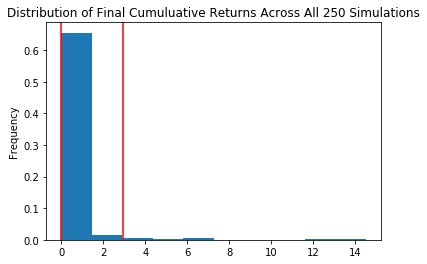

In [9]:
MC.plot_distribution();

### This graph shows a low volatile outcome is more likely.

In [10]:
tbl = MC.summarize_cumulative_return()

initial_investment = int(input("Input the amount of money you'd like to forecast in this analysis: $"))

ci_lower = round(tbl[8]*initial_investment,2)

ci_upper = round(tbl[9]*initial_investment,2)

# Print Results
print(f"""

There is a 95% chance that an initial investment of ${initial_investment} in the portfolio
over the next {num_years} years will end within in the range of ${ci_lower} and ${ci_upper}""")

Input the amount of money you'd like to forecast in this analysis: $ 1000




There is a 95% chance that an initial investment of $1000 in the portfolio
over the next 10 years will end within in the range of $0.28 and $2945.35


### These projections are based on the lower and upper confidence intervals.